# Introduction

The aim of this notebook is to introduce the driver class *PyVisa_Keysight_34465A* utilizing the programmable digital multimeter (DMM) **Keysight 34465A** in my lab.

Sources (small selection):

- Basic functions for controlling test equipment with PyVisa: [https://github.com/freq0ut/Python-PyVisa](https://github.com/freq0ut/Python-PyVisa)
- Automating Test-Equipment with Python: [https://core-electronics.com.au/tutorials/automating-test-equipment-with-python.html](https://core-electronics.com.au/tutorials/automating-test-equipment-with-python.html)
- [Truevolt Series Digital Multimeters Operating and Service Guide, 2021-09-28](https://www.keysight.com/gb/en/assets/9018-03876/service-manuals/9018-03876.pdf)

## Installation of required Python libraries

In this application [PyVisa](https://pypi.org/project/PyVISA/) and [PyVISA-py](https://github.com/pyvisa/pyvisa-py) are used to communicate with the Keysight 34465A via LAN (TCP/IP) interface and SCPI commands. The communication over the USB device port I didn't tested yet.

On Raspberry Pi both Python packages have to be installed first either via *pip* command or using *conda*.

Without conda, the installation is sensibly carried out in a Python *virtualenv* environment:
```
$ source ~/jupyter-env/bin/activate
$ pip install pyvisa pyvisa-py
```

## Load globally used libraries and set plot parameters

In [21]:
import time

from IPython.display import Image

# Short technical overview of the Rigol DP832A

The **Keysight 34465A Truevolt digital multimeter** comes with graphical color display for displaying measurement curves, histograms, bar graphs, statistics and mathematical functions.

The DMM with "Truevolt" technology offers a 6½-digit resolution and a multitude of measurement options and measured value displays that are unique for a DMM. The term "Truevolt" stands for an innovative, patented A/D converter technology with which external factors such as noise and the load on the measuring point are eliminated by the measurement.

Following documentation were helpful for further understanding (found [here](https://www.keysight.com/gb/en/support/34465A/digital-multimeter-6-5-digit-truevolt-dmm.html)):

- [Truevolt Series Digital Multimeters Operating and Service Guide, 2021-09-28](https://www.keysight.com/gb/en/assets/9018-03876/service-manuals/9018-03876.pdf)

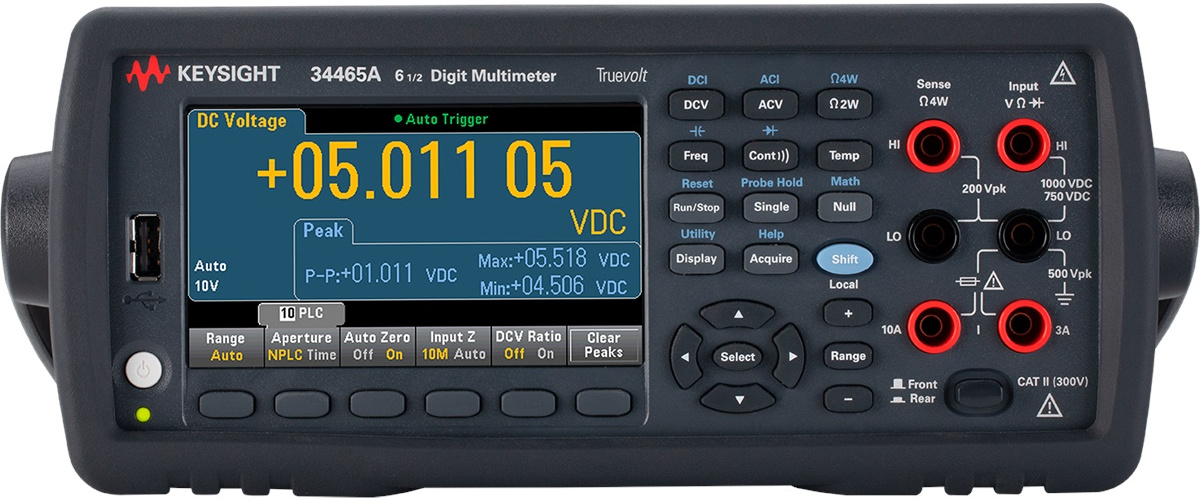

In [7]:
Image('images/keysight-34465A-front.jpg', height=100)

# Remote control of the Rigol DP832A by SCPI commands

The device can be controlled remotely with SCPI commands through a variety of interfaces. The following interfaces are available:

- USB
- LAN
- GPIB (optional)

Control of the device can be integrated into your own applications, or by using LabView via these interfaces.

In this application [PyVisa](https://pypi.org/project/PyVISA/) and [PyVISA-py](https://github.com/pyvisa/pyvisa-py) are used to communicate with the Keysight 34465A via LAN (TCP/IP) interface and SCPI commands. The communication over the USB device port I didn't tested yet.

## Bash and *netcat*: Manual sending of SCPI commands

For initial testing, single SCPI commands can be sent to the Keysight 34465A via the Bash command line using the **netcat** tool. As an example, the device identification is requested in the following:

```
$ echo "*IDN?" | netcat -q 1 192.168.12.150 5025
Keysight Technologies,34465A,MY60033218,A.03.03-03.15-03.03-00.52-05-02
```

The SCPI command is piped to the netcat tool provided with the IP of the DMM and the SCPI port (5025).

The idea was found here:
- [Instrument control using SCPI and Bash scripts](https://hoeckerson.de/notes/2014/04/instrument-control-using-scpi-and-bash-scripts/)
- [Test & measurement home lab | Remote control | Netcat - using sockets](http://www.tio.cz/doku.php?id=projects:test_and_measurement_home_lab#remote_control)

### Measure temperature with 4-wire PT100

Following example assumes that a 4-wire RTD (here an PT100) is connected to the measuring ports.

**Hint:** If the device does *not* respond with a "beep" and on-screen error message, the command was successful.

Reset device:
```
$ echo "*RST" | netcat -q 1 192.168.10.113 5025
```

The desired measurement has to be configured first by issuing:

```
$ echo "FUNC 'TEMP'" | netcat -q 1 192.168.10.113 5025
$ echo "TEMP:TRAN:TYPE FRTD" | netcat -q 1 192.168.10.113 5025
$ echo "TEMP:TRAN:FRTD:RES 100.0" | netcat -q 1 192.168.10.113 5025
```

Verify the configuration with:
```
$ echo "CONF?" | netcat -q 1 192.168.10.113 5025
"TEMP FRTD,85,+1.00000000E+00,+1.00000000E-07"
```

Select the units (°C, °F or Kelvin) to be used for all temperature measurements:
```
$ echo "UNIT:TEMP C" | netcat -q 1 192.168.10.113 5025
```

Trigger the measurement as single shot:
```
$ echo "MEAS:TEMP?" | netcat -q 1 192.168.10.113 5025
```

Perform 1 measurement and read it back
```
$ echo "SAMP:COUN 1" | netcat -q 1 192.168.10.113 5025
$ echo "READ?" | netcat -q 1 192.168.10.113 5025
```

Retrieve 1 dataset:
```
$ echo "DATA:REM? 1, WAIT" | netcat -q 1 192.168.10.113 5025
```

## Using the wrapper class 'PyVisa_Keysight_34465A' manually

The new wrapper class **PyVisa_Keysight_34465A** in the python file *PyVisa_Keysight_34465A_class.py* implements the communication with the DMM Keysight 34465A via LAN interface and SCPI commands using PyVisa and PyVISA-py.

In [1]:
# import wrapper class PyVisa_Keysight_34465A from python file PyVisa_Keysight_34465A_class.py
from PyVisa_Keysight_34465A_class import PyVisa_Keysight_34465A, MeasType, MeasConfig

In [2]:
# IP of devices
#ip_str = '192.168.12.150'
ip_str = '192.168.10.113'

# create new device object for the power supply unit Rigol DP832A
dmm = PyVisa_Keysight_34465A(tcp_ip = ip_str)

In [3]:
# read connection state of the device
dmm.status

'Connected'

In [4]:
# read connection path (at the moment there is only TCP/IP implemented)
dmm.connected_with

'LAN over 192.168.10.113'

In [17]:
# close the connection to the device
dmm.closeConnection()

In [6]:
# open the connection again
dmm.openConnection(ip_str)

In [5]:
# configure DMM for temperature measurement
measConf = MeasConfig()

#measConf.TProbeType = 'RTD'  # 2-wire RTD
#measConf.TProbeConf = '1000' # R_0 for PT1000 (in Ohm)
#measConf.TProbeUnit = 'C'    # select unit °C

#measConf.TProbeType = 'FRTD' # 4-wire RTD
#measConf.TProbeConf = '100'  # R_0 for PT100 (in Ohm)
#measConf.TProbeUnit = 'C'    # select unit °C

#measConf.TProbeType = 'TC'   # TCouple
#measConf.TProbeConf = 'K'    # TCouple of type K
#measConf.TProbeUnit = 'C'    # select unit °C

#measConf.TProbeType = 'THER'  # 2-wire thermistor (NTC)
#measConf.TProbeConf = '5000'  # R_0 for NTC (in Ohm)
#measConf.TProbeUnit = 'C'     # select unit °C

measConf.TProbeType = 'FTH'   # 4-wire thermistor (NTC)
measConf.TProbeConf = '10000' # R_0 for NTC (in Ohm)
measConf.TProbeUnit = 'C'     # select unit °C

dmm.confTempMeasure(measConf)

In [6]:
import time

while True:
    try:
        # retrieve temperature value
        temp = dmm.getMeasurement()
        print("<{:s}> Temperature: {:.7f} °C".format(time.strftime('%H:%M:%S'), temp))
        time.sleep(0.5)
    
    except:
        print("Keyboard Interrupt ^C detected.")
        print("Bye.")
        break

<16:07:14> Temperature: 23.1866750 °C
<16:07:15> Temperature: 23.1753977 °C
<16:07:16> Temperature: 23.1646415 °C
<16:07:17> Temperature: 23.1554681 °C
<16:07:18> Temperature: 23.1460755 °C
<16:07:19> Temperature: 23.1360310 °C
<16:07:20> Temperature: 23.1256521 °C
<16:07:21> Temperature: 23.1174000 °C
<16:07:22> Temperature: 23.1129194 °C
<16:07:23> Temperature: 24.4481054 °C
<16:07:24> Temperature: 27.0509572 °C
<16:07:25> Temperature: 28.4392301 °C
<16:07:26> Temperature: 29.2412211 °C
<16:07:27> Temperature: 29.7538811 °C
<16:07:27> Temperature: 30.0998204 °C
<16:07:28> Temperature: 30.3338745 °C
<16:07:29> Temperature: 30.4653197 °C
<16:07:30> Temperature: 30.9545604 °C
<16:07:31> Temperature: 31.3050535 °C
<16:07:32> Temperature: 31.5105300 °C
<16:07:33> Temperature: 31.6496258 °C
<16:07:34> Temperature: 31.7599883 °C
<16:07:35> Temperature: 31.8648150 °C
<16:07:36> Temperature: 31.9388296 °C
<16:07:37> Temperature: 31.9879468 °C
<16:07:38> Temperature: 32.0206967 °C
<16:07:39> T